In [7]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    classification_report
)
from scipy.sparse import issparse
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

### Reading in the predicted test results from all models

In [10]:
indir = '../../Data/GoogleDrive/'

X_train = indir + 'X_train.parquet'
X_test = indir + 'X_test.parquet'
y_train = indir + 'y_train.parquet'
y_test = indir + 'y_test.parquet'
test_predicted = indir + 'test_predicted.parquet'

X_train = pd.read_parquet(X_train)
X_test = pd.read_parquet(X_test)
y_train = pd.read_parquet(y_train)
y_test = pd.read_parquet(y_test)
test_predicted = pd.read_parquet(test_predicted)

y_pred_test_logi = test_predicted['logi_predicted']
y_pred_prob_logi = test_predicted['logi_predicted_prob']
y_pred_test_knn = test_predicted['knn_predicted']
y_pred_prob_knn = test_predicted['knn_predicted_prob']

# add RF and XGB predictions below

### Logistic Regression Model Performance

=========== Logistic Regression Classification Report ==========
                  precision    recall  f1-score   support

 No_HeartDisease       0.90      0.98      0.94     86858
Yes_HeartDisease       0.57      0.16      0.25     11817

        accuracy                           0.89     98675
       macro avg       0.73      0.57      0.60     98675
    weighted avg       0.86      0.89      0.86     98675

===================== Logistic Regression AUC score ===============
0.8437219515687409



Text(0.5, 1.0, ' Logistic Regression ROC curve')

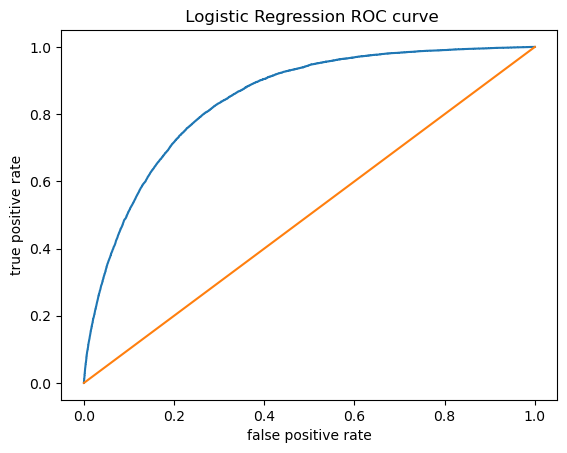

In [15]:
# create classification report
logi_report  = classification_report(y_test, y_pred_test_logi, 
                                     target_names = ['No_HeartDisease', 
                                                     'Yes_HeartDisease'])
# create confusion matrix
logi_conf = confusion_matrix(y_test, y_pred_test_logi)
logi_conf = pd.DataFrame(logi_conf, 
                         columns = ['predicted_no_heart_disease', 
                                    'predicted_heart_disease'],
                         index = ['no_heart_disease',
                                  'has_heart_disease'])

print('=========== Logistic Regression Classification Report ==========')
print(logi_report)
# plotting the ROC curve and printing the AUC score for the logistic model
print('===================== Logistic Regression AUC score ===============')
print(metrics.roc_auc_score(y_test,y_pred_prob_logi))
print('===================================================================\n')
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_prob_logi)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title(' Logistic Regression ROC curve')


=========== Logistic Regression Confusion Matrix ==========
                   predicted_no_heart_disease  predicted_heart_disease
no_heart_disease                        85410                     1448
has_heart_disease                        9882                     1935



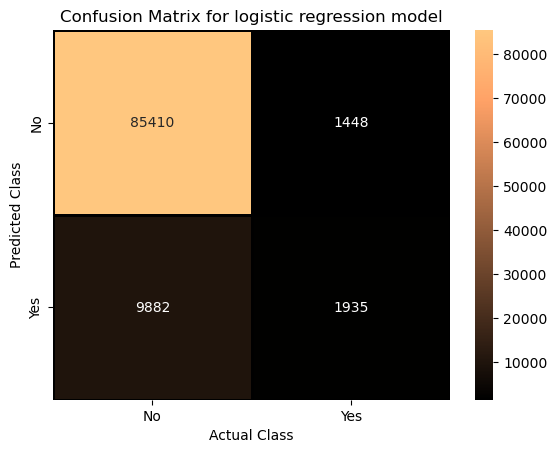

In [16]:
sns.heatmap(confusion_matrix(y_test, y_pred_test_logi),
    annot = True,
    cmap = "copper",
    linewidths = 2,
    linecolor = "black",
    xticklabels = ['No','Yes'],
    yticklabels = ['No','Yes'],
    fmt = '.0F'
           )
plt.title('Confusion Matrix for logistic regression model')
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')

print('=========== Logistic Regression Confusion Matrix ==========')
print(logi_conf)
print('==========================================================\n')

In [17]:
# Getting coefficients
logi_coef = log_final.coef_
avg_coef = np.mean(logi_coef, axis=0)

# create a dictionary for coefficients and column names
coef_dict = {}
for coef, col in zip(avg_coef, X_train.columns):
    coef_dict[col] = coef

# sort the dictionary by the absolute value of the coefficients
sorted_dict = dict(sorted(coef_dict.items(), 
                          key = lambda x: abs(x[1]), 
                          reverse = True))

# dataframe for the sorted dictionary with two columns
coef_df = pd.DataFrame(list(sorted_dict.items()), 
                       columns = ['Feature', 'Coefficient'])

# select the top 10 coefficients
coef_df = coef_df.head(10)
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')

# add text annotation on the bar
for i, v in enumerate(coef_df['Coefficient']):
    plt.text(v, i, str(round(v, 2)),
             color='black', fontweight='bold',
             ha = 'left') 
plt.title('Top 10 Features from logistic regression')
# set x limit
plt.xlim(-0.45, 0.35)
plt.size = (8,6)

NameError: name 'log_final' is not defined

### KNN model performance

=========== KNN Classification Report ==========
                  precision    recall  f1-score   support

 No_HeartDisease       0.89      1.00      0.94     86858
Yes_HeartDisease       0.61      0.05      0.09     11817

        accuracy                           0.88     98675
       macro avg       0.75      0.52      0.51     98675
    weighted avg       0.85      0.88      0.84     98675

===================== KNN AUC score ===============
0.8119107223850621



Text(0.5, 1.0, ' KNN ROC curve')

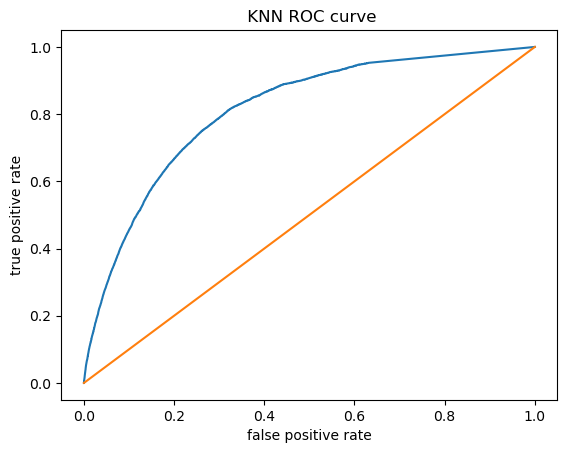

In [19]:
knn_report  = classification_report(y_test, y_pred_test_knn, 
                                     target_names = ['No_HeartDisease', 
                                                     'Yes_HeartDisease'])
# create confusion matrix
knn_conf = confusion_matrix(y_test, y_pred_test_knn)
knn_conf = pd.DataFrame(knn_conf, 
                         columns = ['predicted_no_heart_disease', 
                                    'predicted_heart_disease'],
                         index = ['no_heart_disease',
                                  'has_heart_disease'])

print('=========== KNN Classification Report ==========')
print(knn_report)
# plotting the ROC curve and printing the AUC score for the logistic model
print('===================== KNN AUC score ===============')
print(metrics.roc_auc_score(y_test,y_pred_prob_knn))
print('===================================================================\n')
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_prob_knn)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title(' KNN ROC curve')

=========== KNN Confusion Matrix ==========
                   predicted_no_heart_disease  predicted_heart_disease
no_heart_disease                        86482                      376
has_heart_disease                       11230                      587



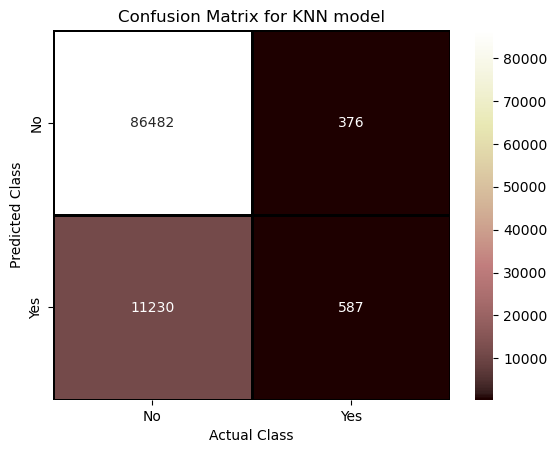

In [20]:
sns.heatmap(confusion_matrix(y_test, y_pred_test_knn),
    annot = True,
    cmap = "pink",
    linewidths = 2,
    linecolor = "black",
    xticklabels = ['No','Yes'],
    yticklabels = ['No','Yes'],
    fmt = '.0F'
           )
plt.title('Confusion Matrix for KNN model')
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')

print('=========== KNN Confusion Matrix ==========')
print(knn_conf)
print('==========================================================\n')

### Random Forest Model Performance

### XGBoost Model Performance